In [51]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import keras
import pickle
import latex

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.initializers import Ones, Zeros, Constant
from keras.models import Model, load_model
from keras.layers import Dense, Input, Lambda, SimpleRNN, Reshape, concatenate, RepeatVector, PReLU, BatchNormalization, LeakyReLU
from keras.losses import mse
from keras.constraints import non_neg

In [52]:
# Change presentation settings

%matplotlib inline

matplotlib.rcParams["figure.figsize"] = (16.0, 10.0)

#matplotlib.rcParams['font.family'] = 'sans-serif'
#matplotlib.rcParams['font.sans-serif'] = ['Liberation Sans']

matplotlib.rcParams["axes.spines.left"] = True
matplotlib.rcParams["axes.spines.top"] = True
matplotlib.rcParams["axes.spines.right"] = True
matplotlib.rcParams["axes.spines.bottom"] = True
matplotlib.rcParams["axes.labelsize"] = 14
matplotlib.rcParams["axes.titlesize"] = 18

matplotlib.rcParams["xtick.top"] = True
matplotlib.rcParams["ytick.right"] = True
matplotlib.rcParams["xtick.direction"] = "in"
matplotlib.rcParams["ytick.direction"] = "in"
matplotlib.rcParams["xtick.labelsize"] = 10
matplotlib.rcParams["ytick.labelsize"] = 10
matplotlib.rcParams["xtick.major.size"] = 10
matplotlib.rcParams["ytick.major.size"] = 10
matplotlib.rcParams["xtick.minor.size"] = 5
matplotlib.rcParams["ytick.minor.size"] = 5
matplotlib.rcParams["xtick.minor.visible"] = True

#matplotlib.rcParams["text.usetex"] = True

matplotlib.rcParams["lines.linewidth"] = 2

matplotlib.rcParams["legend.fontsize"] = 14

color_palette = {"Indigo": {
                    50: "#E8EAF6",
                    100: "#C5CAE9",
                    200: "#9FA8DA",
                    300: "#7986CB",
                    400: "#5C6BC0",
                    500: "#3F51B5",
                    600: "#3949AB",
                    700: "#303F9F",
                    800: "#283593",
                    900: "#1A237E"},
                 "Orange": {      
                    50: "#FFF3E0",
                    100: "#FFE0B2",
                    200: "#FFCC80",
                    300: "#FFB74D",
                    400: "#FFA726",
                    500: "#FF9800",
                    600: "#FB8C00",
                    700: "#F57C00",
                    800: "#EF6C00",
                    900: "#E65100"}
                }

line_styles = [(0, ()), (0, (1, 2)), (0, (3, 2))]

In [53]:
def plot_loss(data, save_name=False):
    """Plots the training and validation loss"""
    fig, ax = plt.subplots()

    plt.xlabel("Epoch", horizontalalignment='right', x=1.0)
    plt.ylabel("Cross-entropy", horizontalalignment='right', y=1.0)

    plt.plot(data["loss"], linestyle=line_styles[0], color=color_palette["Indigo"][800])
    plt.plot(data["val_loss"], linestyle=line_styles[2], color=color_palette["Orange"][400])
    plt.legend(["Training data set", "Validation data set"], loc="upper right", frameon=False)
    #plt.yscale("log")
    
    if save_name:
        fig.savefig("%s/%s.eps" % (figure_export_directory, save_name), bbox_inches="tight")

    plt.show();

In [54]:
def train_nn(model, x, y, batch_size, loss, name, xval, pval):
    
    adam = keras.optimizers.Adam(lr=0.003,
                                 beta_1=0.9,
                                 beta_2=0.999,
                                 epsilon=None,
                                 decay=0.0,
                                 amsgrad=False)

    early_stopper = EarlyStopping(monitor="val_loss",
                                  patience=32,
                                  verbose=True,
                                  mode="auto")

    reduce_lr = ReduceLROnPlateau(monitor="val_loss",
                                  factor=0.1,
                                  patience=24)
    
    checkpoint_callback = ModelCheckpoint(("%s.h5" % (name)),
                                          monitor="val_loss",
                                          verbose=False,
                                          save_best_only=True,
                                          mode="min")
    
    model.compile(loss=loss, optimizer=adam)
    
    history = model.fit([x,y], x,
                     batch_size=batch_size,
                     epochs=1000,
                     verbose=2,
                     initial_epoch=0,
                     shuffle=True,
                     validation_data=([xval,pval],xval),
                     callbacks=[early_stopper, checkpoint_callback])
    return history

## Data

In [55]:
good_data_file = 'Pileup_data.pickle'
bad_data_file = 'Pileup_bad.pickle'

subplot_size = [2,3]
fig_size = [20,20]

runs = [302263,304508,302597]

with open(good_data_file, 'rb') as handle:
    data = pickle.load(handle)
with open(bad_data_file, 'rb') as handle:
    bad_data = pickle.load(handle)

x_train = np.array(data[str(runs[0])]['samples'])
pileup_train = np.array(data[str(runs[0])]['pileupInput'][0])
x_val = np.array(data[str(runs[1])]['samples'])
pileup_val = np.array(data[str(runs[1])]['pileupInput'][0])
x_test = np.array(data[str(runs[2])]['samples'])
pileup_test = np.array(data[str(runs[2])]['pileupInput'][0])

print(bad_data.keys())

x_bad1 = np.array(bad_data['301480']['samples'])
pileup_bad1 = np.array(bad_data['301480']['pileupInput'][0])
x_bad2 = np.array(bad_data['305588']['samples'])
pileup_bad2 = np.array(bad_data['305588']['pileupInput'][0])

num_rates = len(x_train[0])
print(num_rates)

dict_keys(['HLT', '301480', '302566', '299592', '305588', '297659'])
6


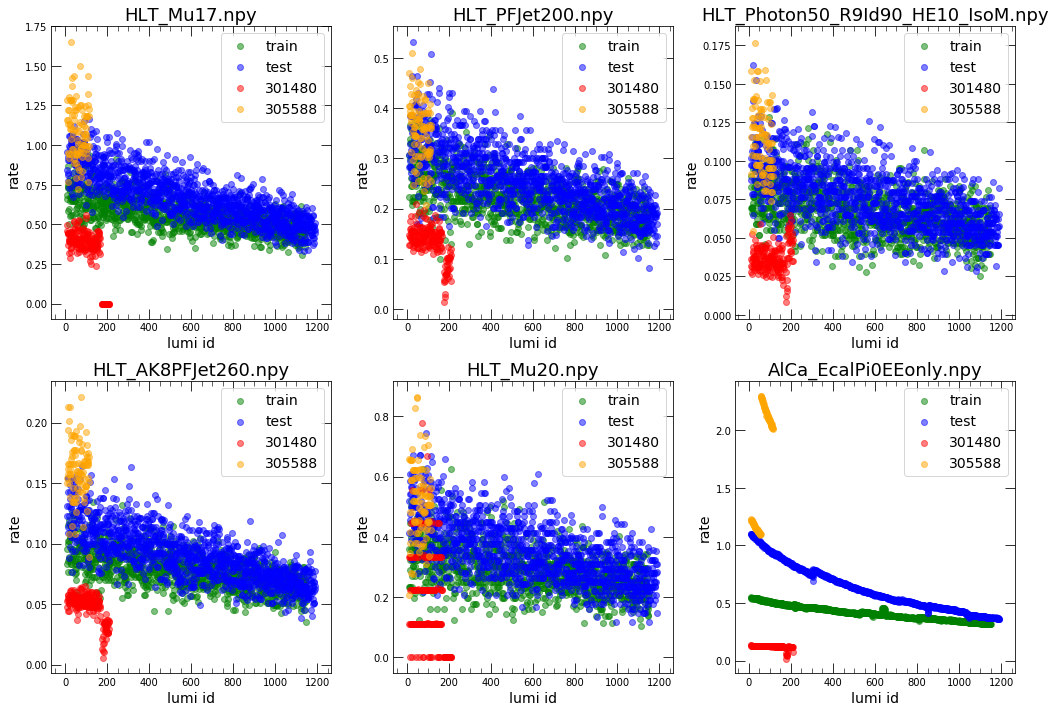

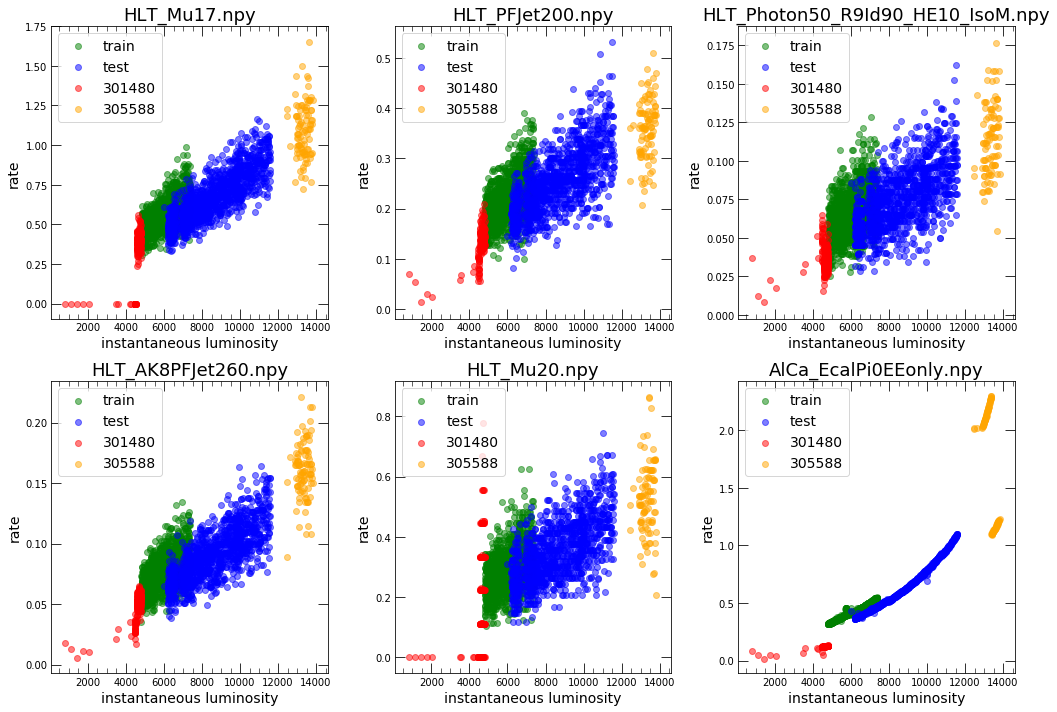

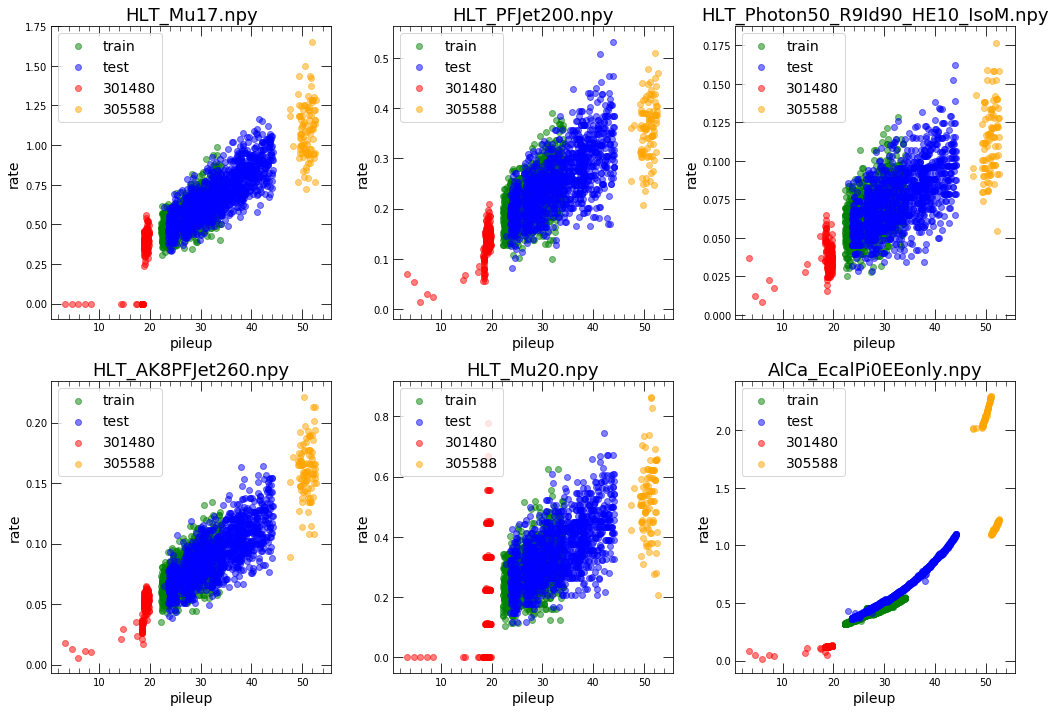

In [56]:
relativeerror = r"$\frac{input rate - output rate}{input rate}$"
sumsquareddif = r"$\sum_{i} (input rate_i-output rate_i)^2$"

plots = [x_train,x_test,x_bad1,x_bad2]
titles = ["train","test","301480","305588"]

stuff = [[],[],[],[]]
lumi = [[],[],[],[]]
inst = [[],[],[],[]]
pileup = [[],[],[],[]]
for h in range(4):
    if h == 0 or h == 1:
        lumi[h] = data[str(runs[h])]['lumiid']
        inst[h] = data[str(runs[h])]['instlumi']
        pileup[h] = data[str(runs[h])]['pileup']
        stuff[h] = data[str(runs[h])]['rates']
    elif h == 2:
        lumi[h] = bad_data["301480"]['lumiid']
        inst[h] = bad_data["301480"]['instlumi']
        pileup[h] = bad_data["301480"]['pileup']
        stuff[h] = bad_data["301480"]['rates']
    else:
        lumi[h] = bad_data["305588"]['lumiid']
        inst[h] = bad_data["305588"]['instlumi']
        pileup[h] = bad_data["305588"]['pileup']
        stuff[h] = bad_data["305588"]['rates']
    
labels = data['HLT'] 
colors = ["g","b","r","orange"]
    
plt.figure(figsize=[15,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(i[k]),len(stuff[k][i]))
        plt.scatter(lumi[k],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(inst[k][i]),len(stuff[k][i]))
        plt.scatter(inst[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('instantaneous luminosity')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    for k in range(4):
        #print(len(lumi[k]),len(stuff[k][i]))
        plt.scatter(pileup[k][i],stuff[k][i],c=colors[k],label=titles[k],alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Simple Autoencoder

In [57]:
model_name = "normedRateAvgCurrent"

In [58]:
# Define the architecture

_input = Input(shape=(6,), name="input")

middle = Dense(5,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation = 'relu',
               name="middle")(_input)

norm = BatchNormalization()(middle)

p_layer = Input(shape=(1,), name="pileup")

concat = concatenate([p_layer,norm])

hidden = Dense(3,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation = 'relu',
               name="encoded")(concat)

normhidden = BatchNormalization()(hidden)

middle2 = Dense(5,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation = 'relu',
               name="middle2")(normhidden)

normmiddle = BatchNormalization()(middle2)

output = Dense(6,
               kernel_initializer=Ones(),
               bias_initializer=Zeros(),
               kernel_constraint=non_neg(),
               bias_constraint=non_neg(),
               activation=None,
               name="reconstructed")(normmiddle)

normout = BatchNormalization()(output)

model = Model([_input,p_layer], normout)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 6)            0                                            
__________________________________________________________________________________________________
middle (Dense)                  (None, 5)            35          input[0][0]                      
__________________________________________________________________________________________________
pileup (InputLayer)             (None, 1)            0                                            
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 5)            20          middle[0][0]                     
__________________________________________________________________________________________________
concatenat

Train on 1129 samples, validate on 1164 samples
Epoch 1/1000
 - 6s - loss: 1.1944 - val_loss: 1.5026
Epoch 2/1000
 - 0s - loss: 1.1770 - val_loss: 1.5136
Epoch 3/1000
 - 0s - loss: 1.1595 - val_loss: 1.4753
Epoch 4/1000
 - 0s - loss: 1.1424 - val_loss: 1.3419
Epoch 5/1000
 - 0s - loss: 1.1254 - val_loss: 1.2825
Epoch 6/1000
 - 0s - loss: 1.1086 - val_loss: 1.2482
Epoch 7/1000
 - 0s - loss: 1.0918 - val_loss: 1.1813
Epoch 8/1000
 - 0s - loss: 1.0752 - val_loss: 1.1294
Epoch 9/1000
 - 0s - loss: 1.0588 - val_loss: 1.0683
Epoch 10/1000
 - 0s - loss: 1.0427 - val_loss: 1.0269
Epoch 11/1000
 - 0s - loss: 1.0264 - val_loss: 0.9863
Epoch 12/1000
 - 0s - loss: 1.0105 - val_loss: 0.9442
Epoch 13/1000
 - 0s - loss: 0.9947 - val_loss: 0.8919
Epoch 14/1000
 - 0s - loss: 0.9792 - val_loss: 0.8523
Epoch 15/1000
 - 0s - loss: 0.9638 - val_loss: 0.8155
Epoch 16/1000
 - 0s - loss: 0.9486 - val_loss: 0.7709
Epoch 17/1000
 - 0s - loss: 0.9336 - val_loss: 0.7293
Epoch 18/1000
 - 0s - loss: 0.9188 - val_lo

Epoch 152/1000
 - 0s - loss: 0.0079 - val_loss: 0.0090
Epoch 153/1000
 - 0s - loss: 0.0079 - val_loss: 0.0090
Epoch 154/1000
 - 0s - loss: 0.0079 - val_loss: 0.0090
Epoch 155/1000
 - 0s - loss: 0.0078 - val_loss: 0.0089
Epoch 156/1000
 - 0s - loss: 0.0078 - val_loss: 0.0089
Epoch 157/1000
 - 0s - loss: 0.0078 - val_loss: 0.0089
Epoch 158/1000
 - 0s - loss: 0.0077 - val_loss: 0.0089
Epoch 159/1000
 - 0s - loss: 0.0077 - val_loss: 0.0089
Epoch 160/1000
 - 0s - loss: 0.0077 - val_loss: 0.0089
Epoch 161/1000
 - 0s - loss: 0.0077 - val_loss: 0.0089
Epoch 162/1000
 - 0s - loss: 0.0076 - val_loss: 0.0088
Epoch 163/1000
 - 0s - loss: 0.0076 - val_loss: 0.0088
Epoch 164/1000
 - 0s - loss: 0.0076 - val_loss: 0.0088
Epoch 165/1000
 - 0s - loss: 0.0076 - val_loss: 0.0088
Epoch 166/1000
 - 0s - loss: 0.0076 - val_loss: 0.0088
Epoch 167/1000
 - 0s - loss: 0.0076 - val_loss: 0.0088
Epoch 168/1000
 - 0s - loss: 0.0075 - val_loss: 0.0088
Epoch 169/1000
 - 0s - loss: 0.0075 - val_loss: 0.0088
Epoch 170/

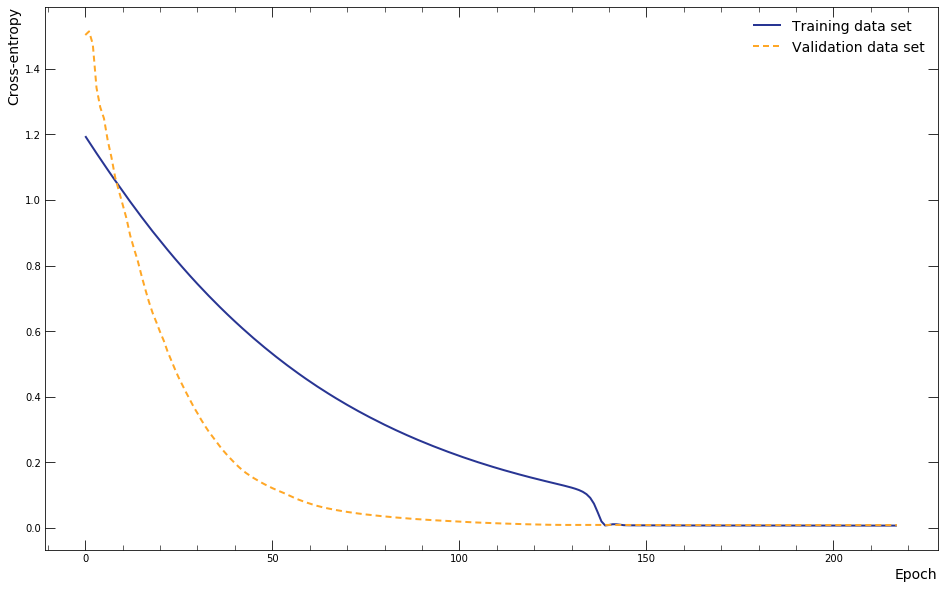

In [59]:
# Train neural networks
history = train_nn(model, x_train, pileup_train, 1024, "mse", model_name, x_val, pileup_val).history
plot_loss(history)

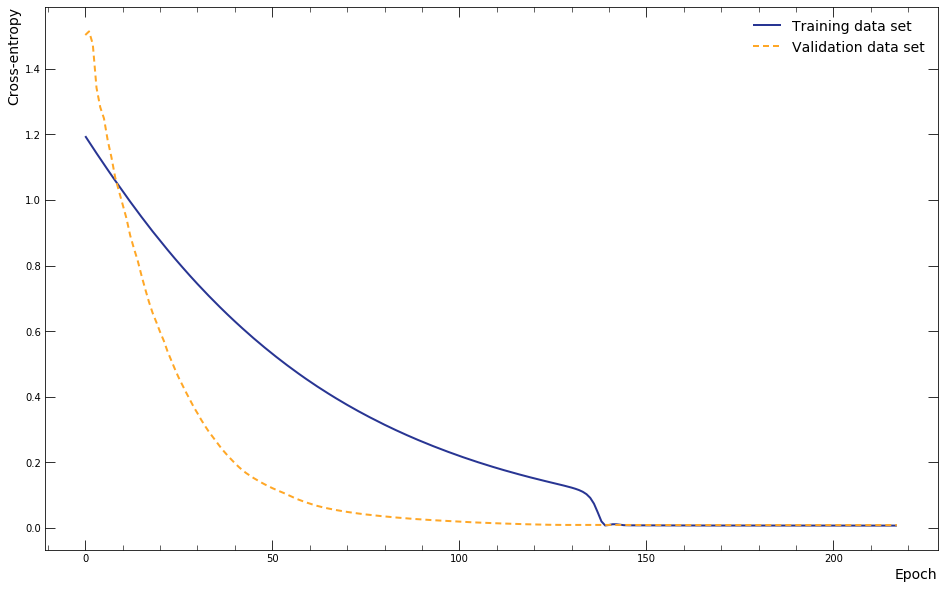

In [60]:
plot_loss(history)

## Training Set

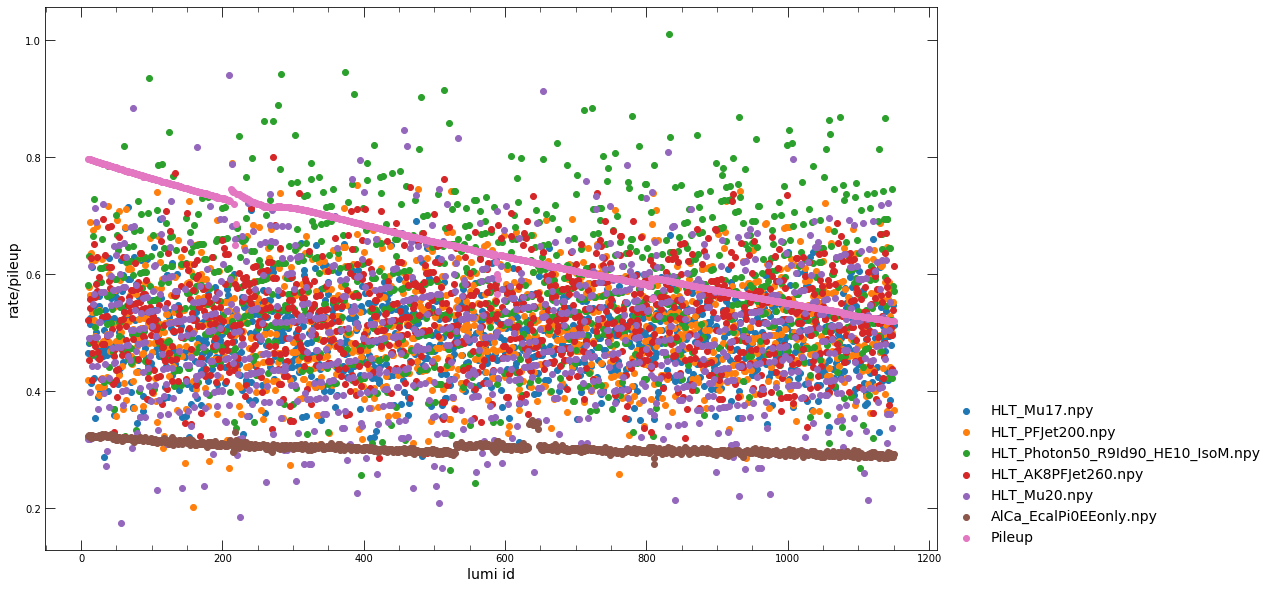

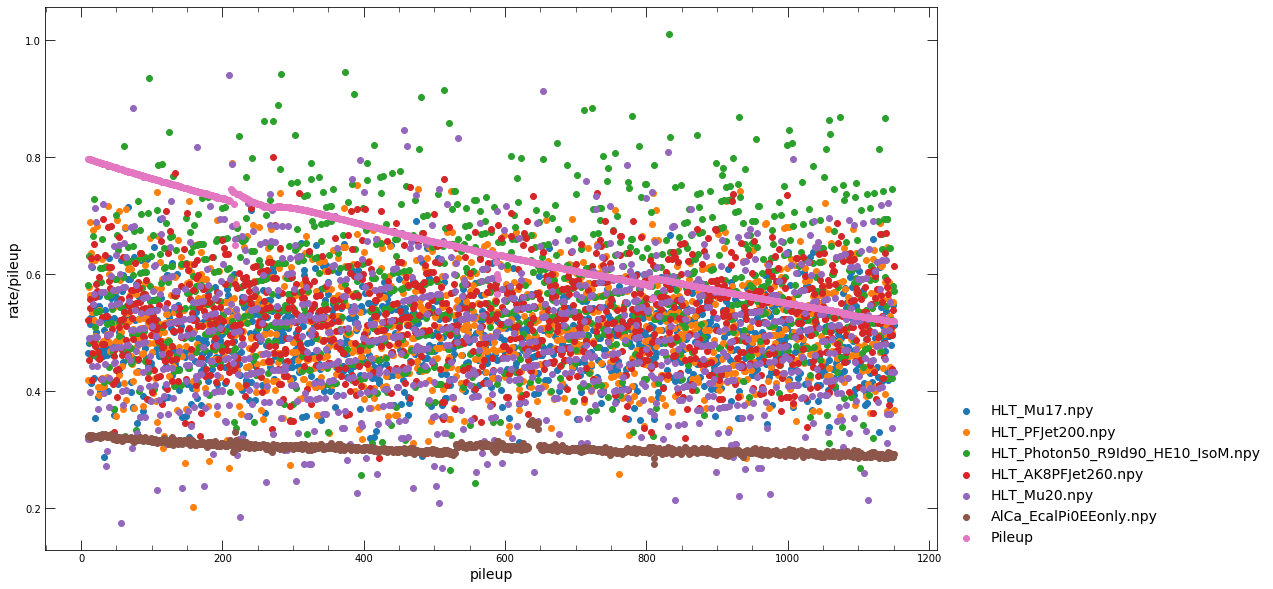

In [61]:
samples = data[str(runs[0])]['samples']
lumi_train = data[str(runs[0])]['lumiid']
pileup_tr = data[str(runs[0])]['lumiid']
inputs = []
for s in range(len(samples)):
    for r in range(len(samples[s])):
        if s == 0:
            inputs.append([])
        inputs[r].append(samples[s][r])
            
plt.figure()
fig,ax=plt.subplots()
for r in range(len(inputs)):
    ax.scatter(lumi_train,inputs[r],label=labels[r])
ax.scatter(lumi_train,pileup_train,label='Pileup')
ax.legend(loc='lower left', bbox_to_anchor= (1.01, 0), ncol=1, 
              borderaxespad=0, frameon=False)
plt.xlabel('lumi id')
plt.ylabel('rate/pileup')

plt.figure()
fig,ax=plt.subplots()
for r in range(len(inputs)):
    ax.scatter(pileup_tr,inputs[r],label=labels[r])
ax.scatter(pileup_tr,pileup_train,label='Pileup')
ax.legend(loc='lower left', bbox_to_anchor= (1.01, 0), ncol=1, 
              borderaxespad=0, frameon=False)
plt.xlabel('pileup')
plt.ylabel('rate/pileup')
plt.show()

In [62]:
# Generate predictions

model = load_model("%s.h5" % (model_name))
             
reconstructed_train = model.predict([np.array(x_train),pileup_train])

error = (x_train-reconstructed_train)/(abs(x_train)+abs(reconstructed_train))

In [63]:
error_train_reformat = []
max_error_train = []
inp = []
outp = []
for i in range(num_rates):
    error_train_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    max_error_train.append(max(error[i]))
    for j in range(num_rates):
        error_train_reformat[j].append(error[i][j])
        outp[j].append(reconstructed_train[i][j])
        inp[j].append(x_train[i][j])

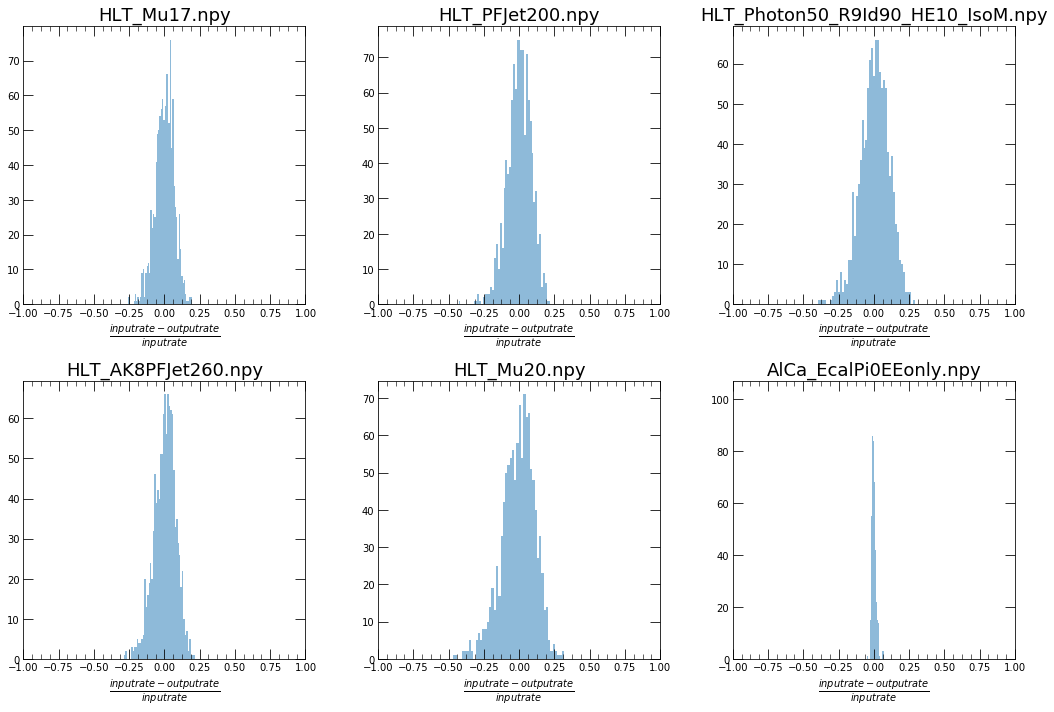

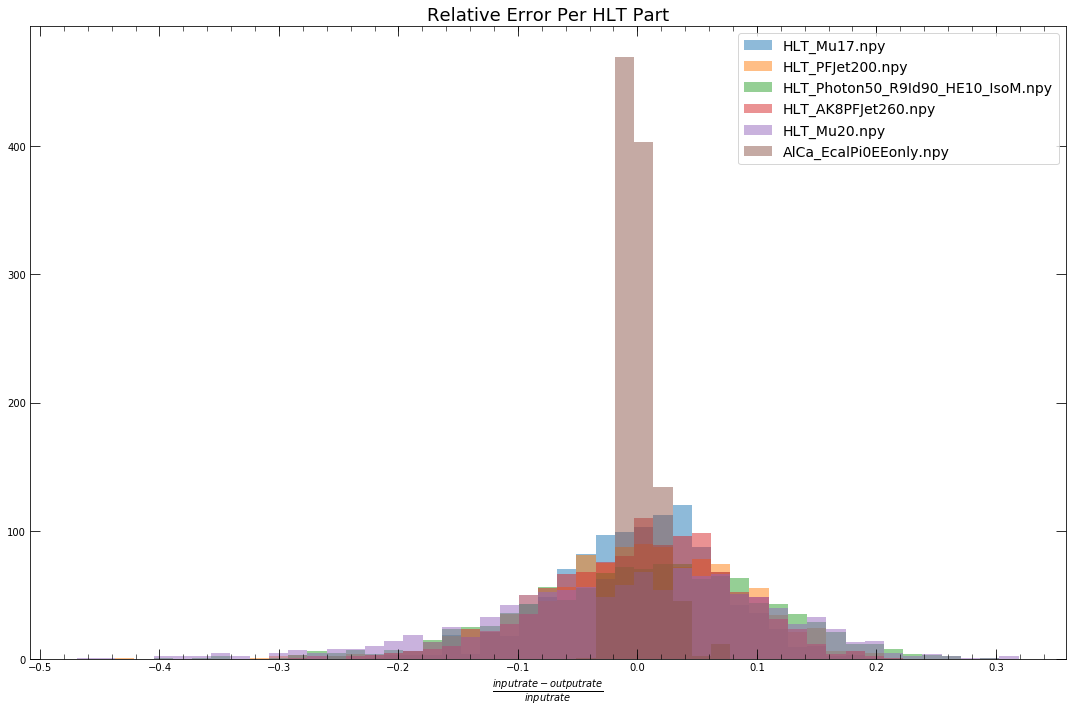

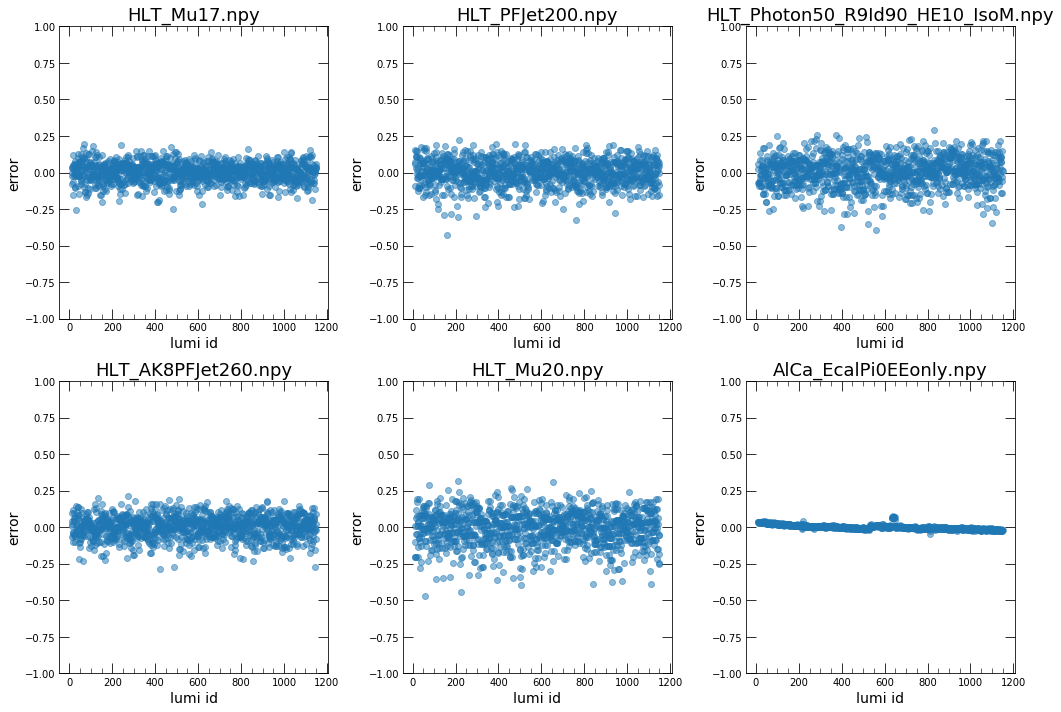

In [64]:
#bins = np.linspace(0,1,50)

plt.figure(figsize=[15,10])
for i in range(len(error_train_reformat)):
    plt.subplot(2,3,i+1)
    bins = np.linspace(min(error_train_reformat[i]),max(error_train_reformat[i]),50)
    plt.hist(error_train_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.title(labels[i])
    plt.xlim(-1,1)
    plt.xlabel(relativeerror)
plt.tight_layout()

plt.figure(figsize=[15,10])
mins = []
maxes = []
for err in error_train_reformat:
    mins.append(min(err))
    maxes.append(max(err))
bins = np.linspace(min(mins),max(maxes),50)
for i in range(len(error_train_reformat)):
    plt.hist(error_train_reformat[i],bins=bins,label=labels[i],alpha=.5)
plt.title('Relative Error Per HLT Part')
plt.xlabel(relativeerror)
plt.legend()
plt.tight_layout()

#lumi_train = np.linspace(0,len(error_train_reformat0]),len(error_train_reformat0]))
plt.figure(figsize=[15,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi_train,error_train_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.ylim(-1,1)
    plt.title(labels[i])    
plt.tight_layout()


plt.show()

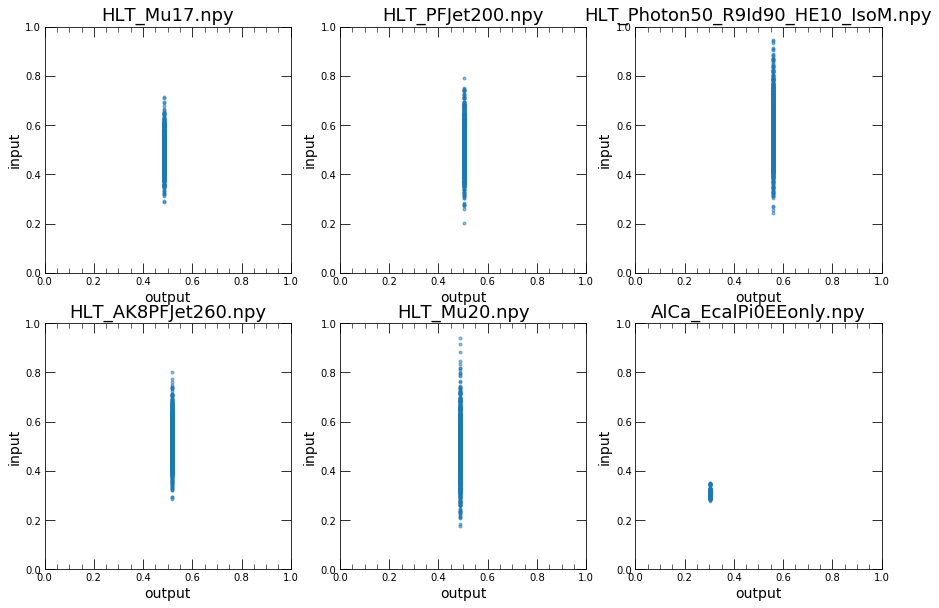

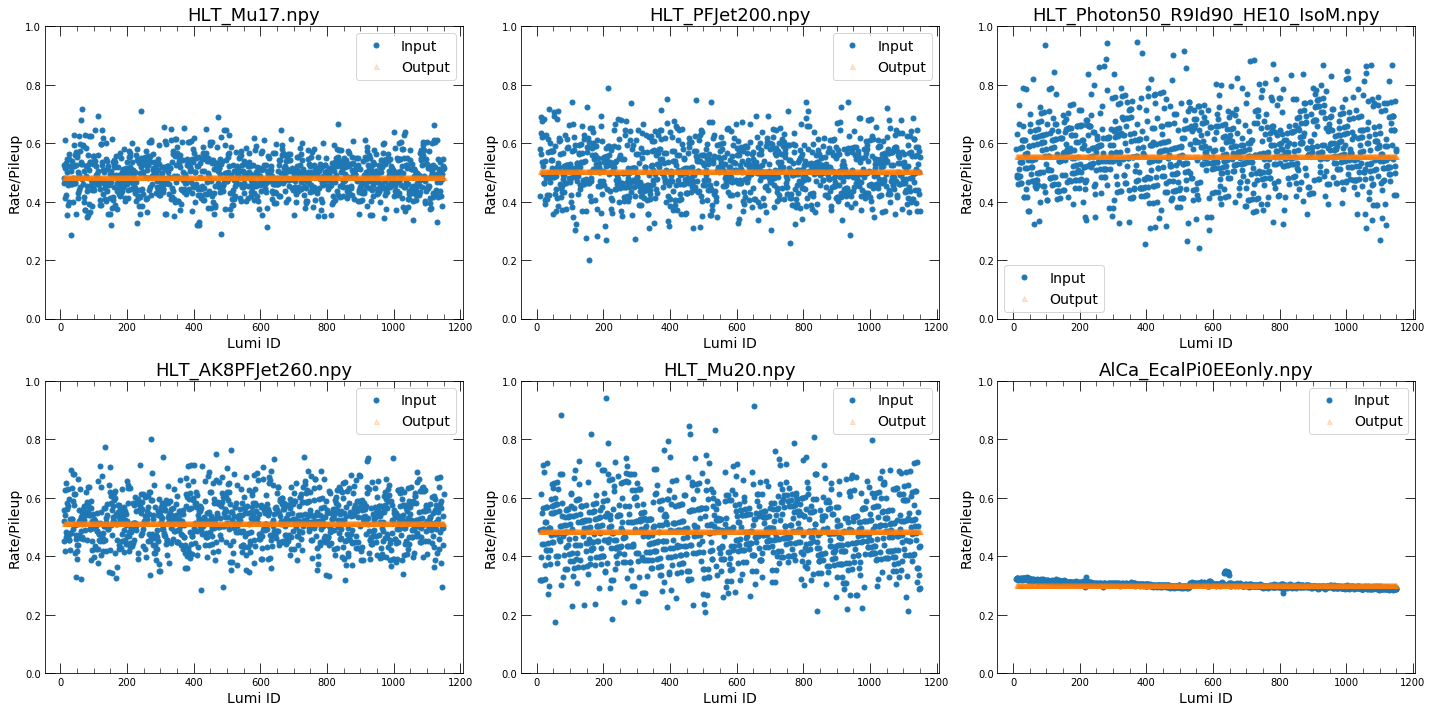

In [65]:
plt.figure(figsize=[15,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi_train,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.title(labels[i])
    plt.axis('square')
    plt.xlim(0,1)
    plt.ylim(0,1)
    
plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(lumi_train,inp[i],label='Input', linestyle='',marker='o', markersize=5)
    plt.plot(lumi_train,outp[i],label='Output', linestyle='',marker='^',markersize=5,alpha=.2)
    plt.title(labels[i])
    plt.xlabel('Lumi ID')
    plt.ylabel('Rate/Pileup')
    #plt.xlim(0,.5)
    plt.ylim(0,1)
    plt.legend()    
plt.tight_layout()
    

plt.tight_layout()
plt.show()

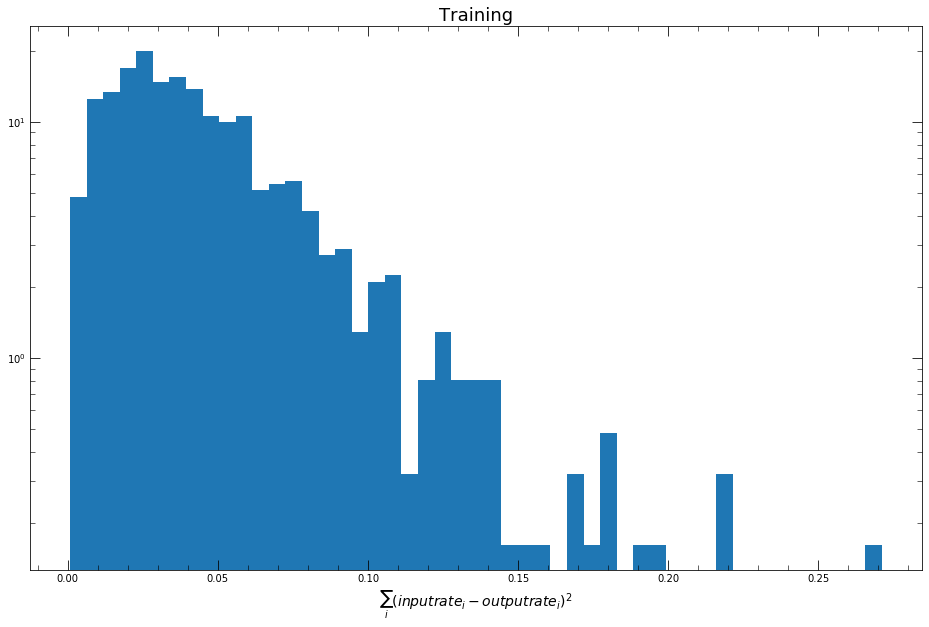

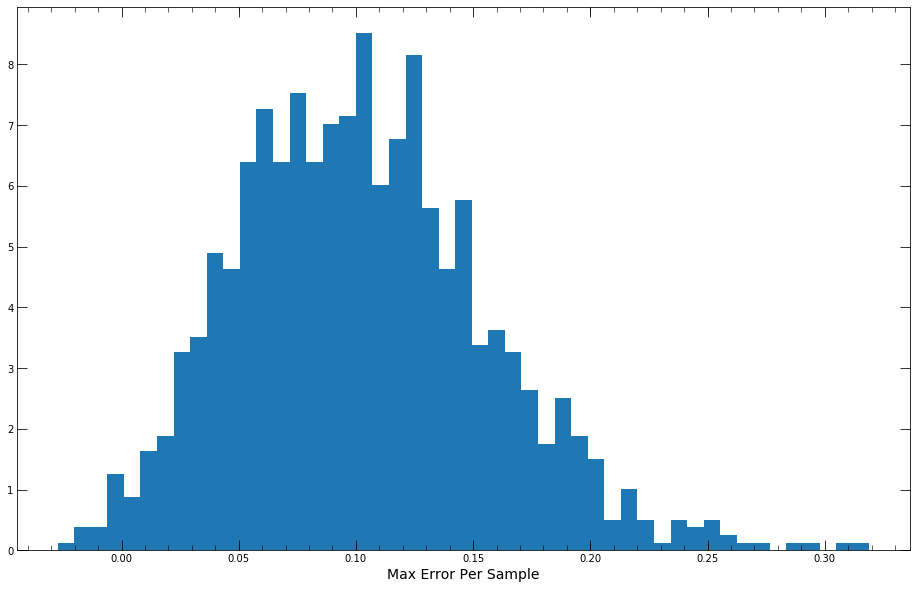

In [66]:
error_train = []
for r in range(len(reconstructed_train)):
    temp = 0
    for s in range(len(reconstructed_train[r])):
        temp+=(reconstructed_train[r][s]-x_train[r][s])**2
    error_train.append(temp)

bins = np.linspace(min(error_train),max(error_train),50)
plt.figure()
plt.hist(error_train,bins=bins,density=True)
plt.xlabel(sumsquareddif)
plt.title('Training')
plt.yscale('log')

plt.figure()
bins = np.linspace(min(max_error_train),max(max_error_train),50)
plt.hist(max_error_train,bins=bins,density=True,label='Training')
plt.xlabel('Max Error Per Sample')

plt.show()

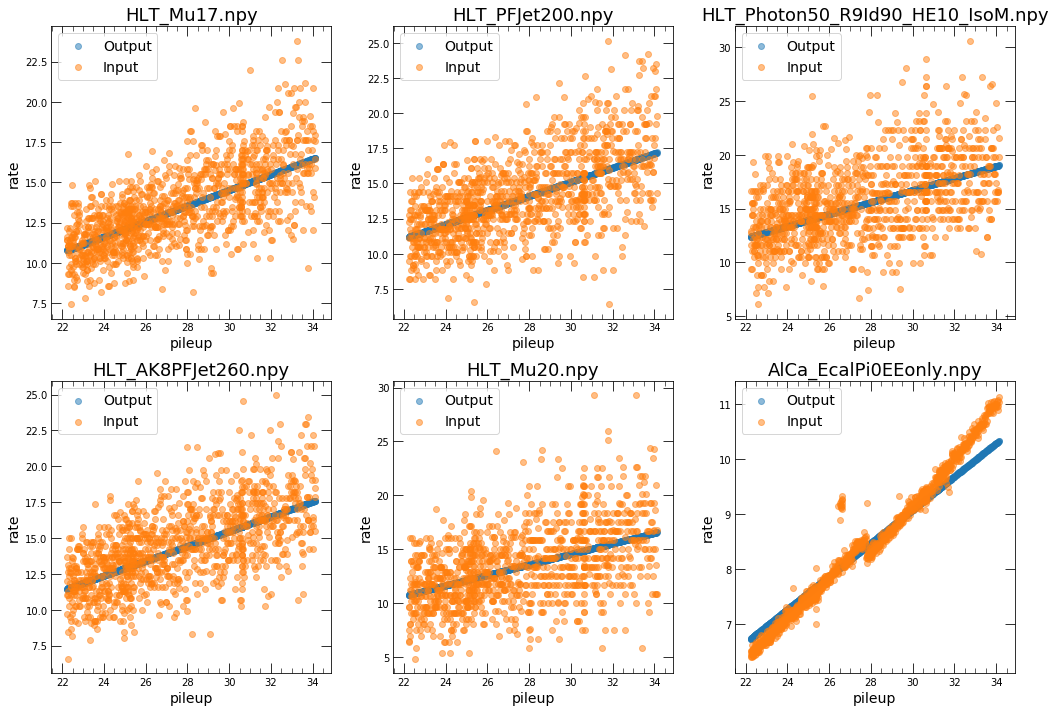

In [67]:
pileup_train = data[str(runs[0])]['pileup'][0]

output_rates = []
input_rates = []

for r in range(num_rates):
    output_rates.append([])
    input_rates.append([])

for r in range(len(reconstructed_train)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_train[r][o]*pileup_train[r])
        input_rates[o].append(x_train[r][o]*pileup_train[r])
    
plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(pileup_train,output_rates[i],label='Output',alpha=.5)
    plt.scatter(pileup_train,input_rates[i],label='Input',alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Test Data

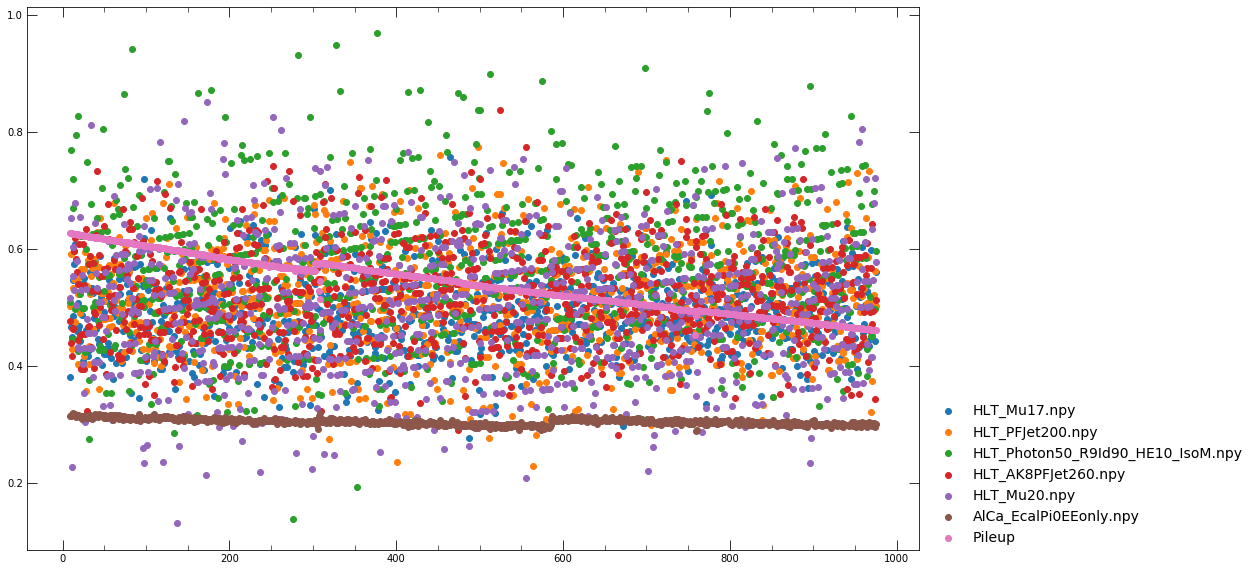

In [68]:
samples = data[str(runs[2])]['samples']
lumi_test = data[str(runs[2])]['lumiid']
inputs = []
for s in range(len(samples)):
    for r in range(len(samples[s])):
        if s == 0:
            inputs.append([])
        inputs[r].append(samples[s][r])
            
plt.figure()
fig,ax=plt.subplots()
for r in range(len(inputs)):
    ax.scatter(lumi_test,inputs[r],label=labels[r])
ax.scatter(lumi_test,pileup_test,label='Pileup')
ax.legend(loc='lower left', bbox_to_anchor= (1.01, 0), ncol=1, 
              borderaxespad=0, frameon=False)
plt.show()

In [69]:
# Generate predictions

model = load_model("%s.h5" % (model_name))

reconstructed_test = model.predict([np.array(x_test),pileup_test])

error = (x_test-reconstructed_test)/(abs(x_test)+abs(reconstructed_test))

In [70]:
error_test_reformat = []
max_error_test = []
inp = []
outp = []
for i in range(num_rates):
    error_test_reformat.append([])
    inp.append([])
    outp.append([])

for i in range(len(error)):
    max_error_test.append(max(error[i]))
    #print(len(error_test_reformat[0]))
    for j in range(num_rates):
        error_test_reformat[j].append(error[i][j])
        outp[j].append(reconstructed_test[i][j])
        inp[j].append(x_test[i][j])

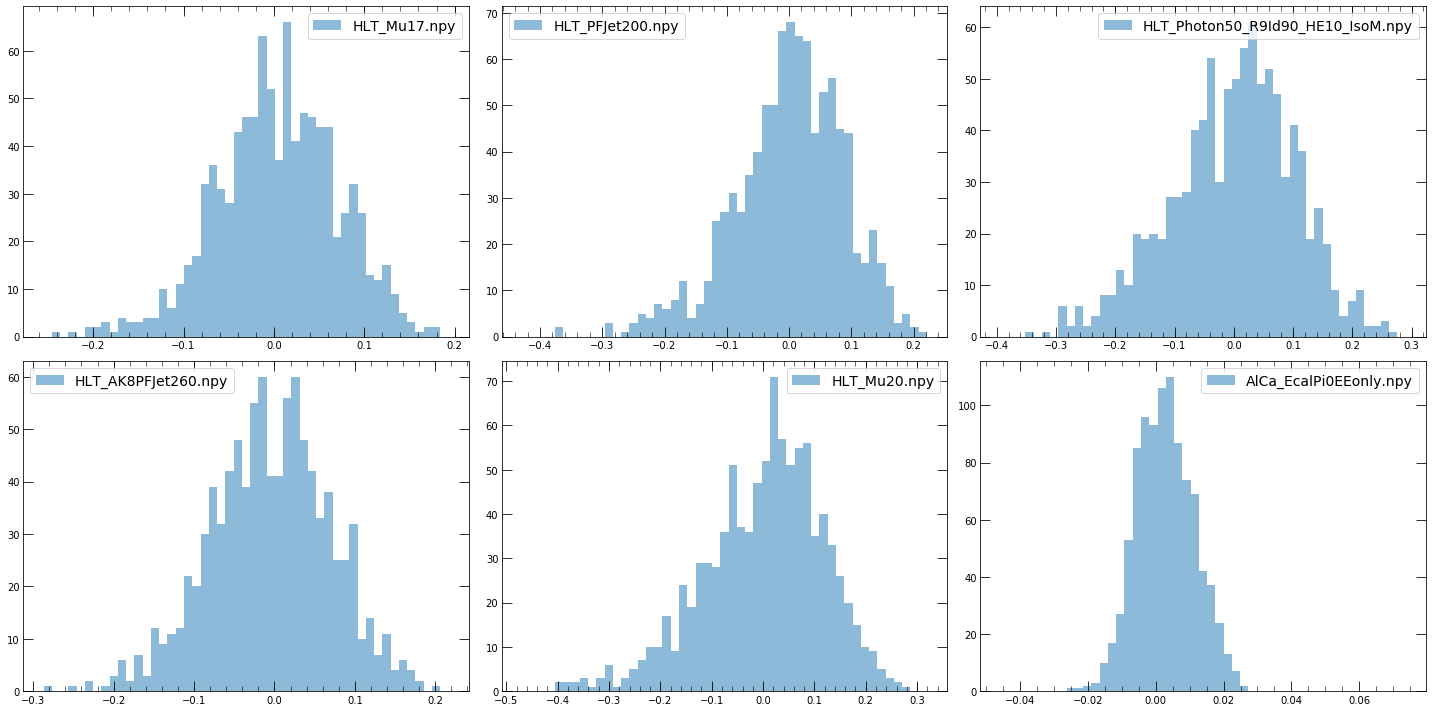

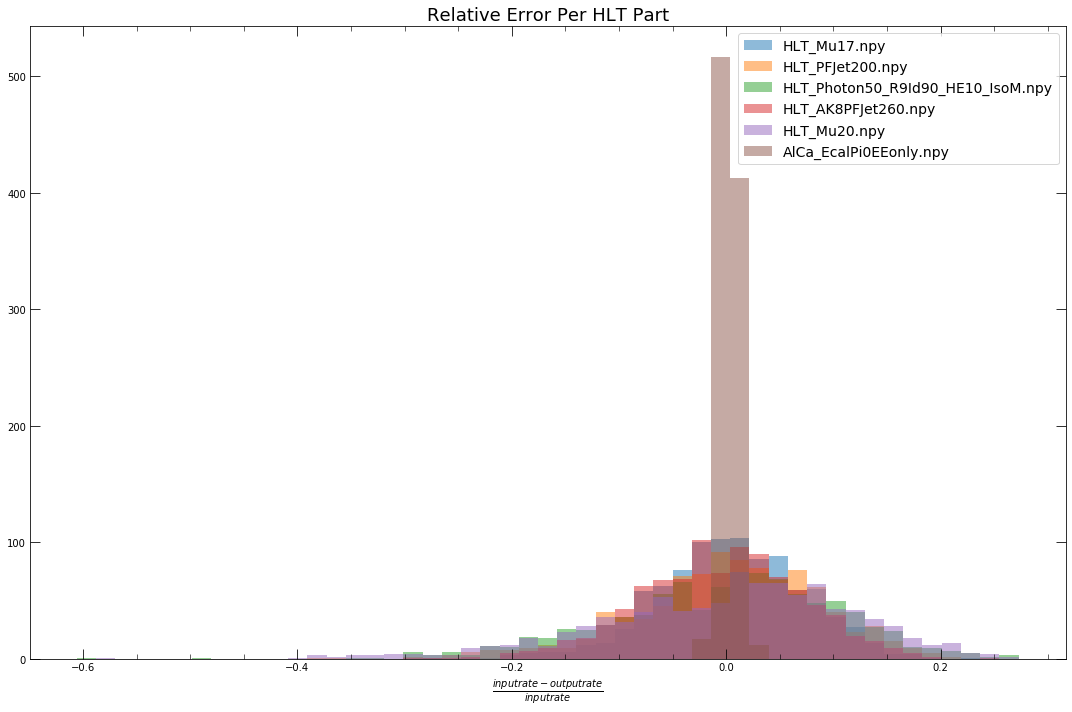

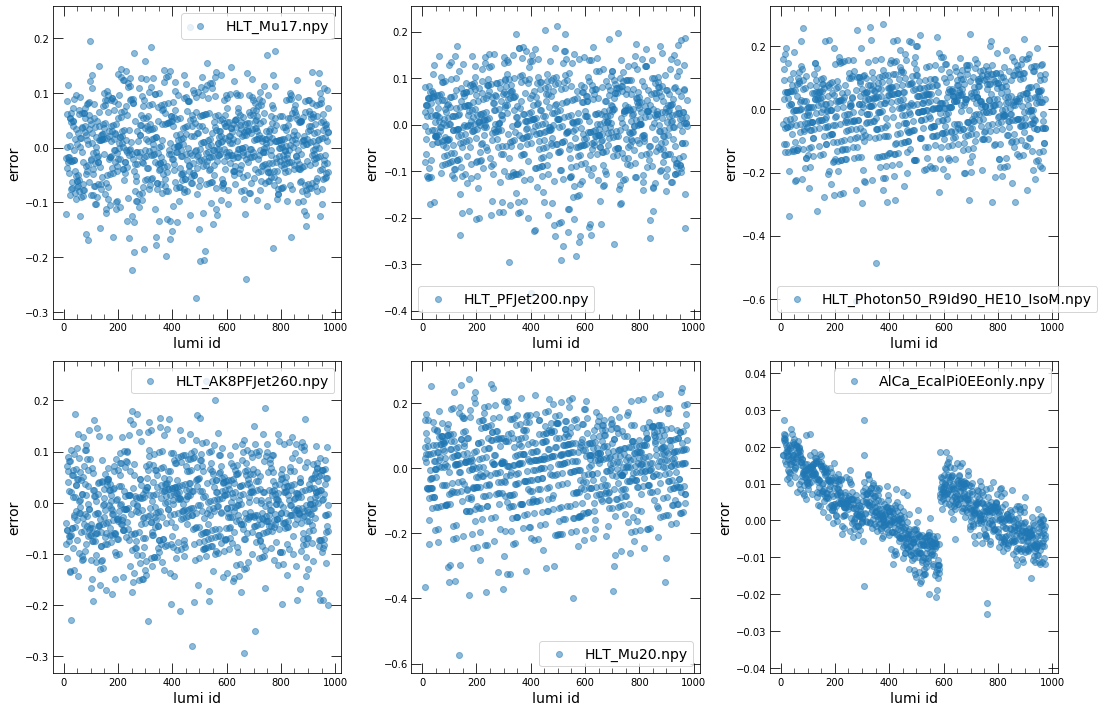

In [71]:
#bins = np.linspace(0,1,50)
plt.figure(figsize=[20,10])
for i in range(len(error_test_reformat)):
    plt.subplot(2,3,i+1)
    bins = np.linspace(min(error_train_reformat[i]),max(error_train_reformat[i]),50)
    plt.hist(error_test_reformat[i],bins=bins,label=labels[i],alpha=.5)
    plt.legend()
    
plt.tight_layout()

plt.figure(figsize=[15,10])
mins = []
maxes = []
for err in error_test_reformat:
    mins.append(min(err))
    maxes.append(max(err))
bins = np.linspace(min(mins),max(maxes),50)
for i in range(len(error_test_reformat)):
    plt.hist(error_test_reformat[i],bins=bins,label=labels[i],alpha=.5)
plt.title('Relative Error Per HLT Part')
plt.xlabel(relativeerror)
plt.legend()
plt.tight_layout()

lumi_test = data[str(runs[2])]['lumiid']
#lumi_test = np.linspace(0,len(error_test_reformat[0]),len(error_test_reformat[0]))
plt.figure(figsize=[15,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi_test,error_test_reformat[i],label=labels[i],alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    

plt.tight_layout()

plt.show()

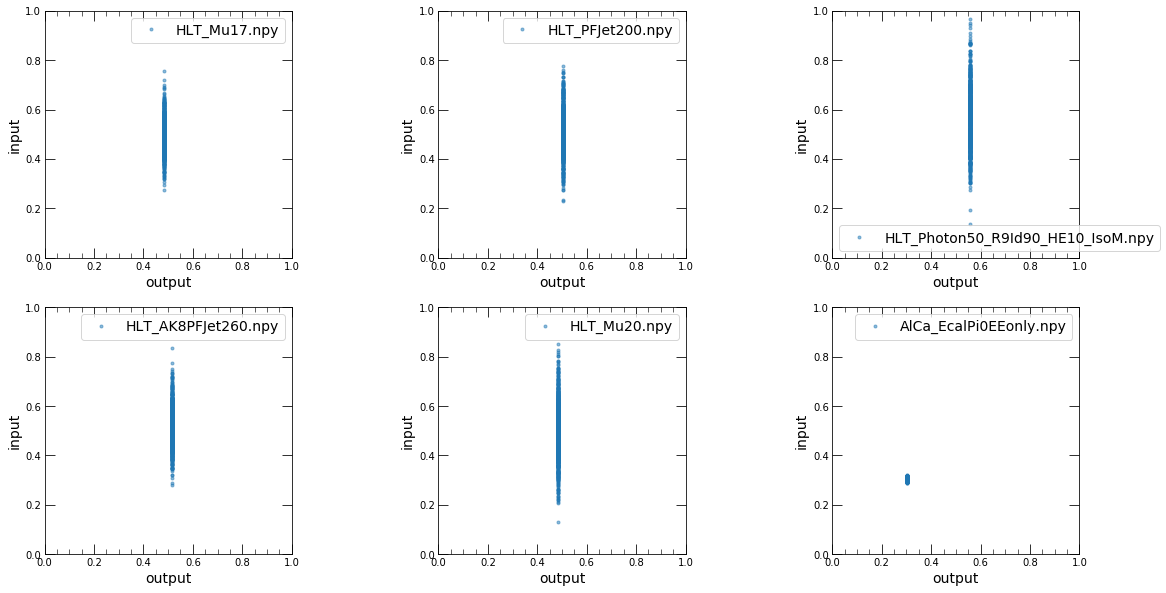

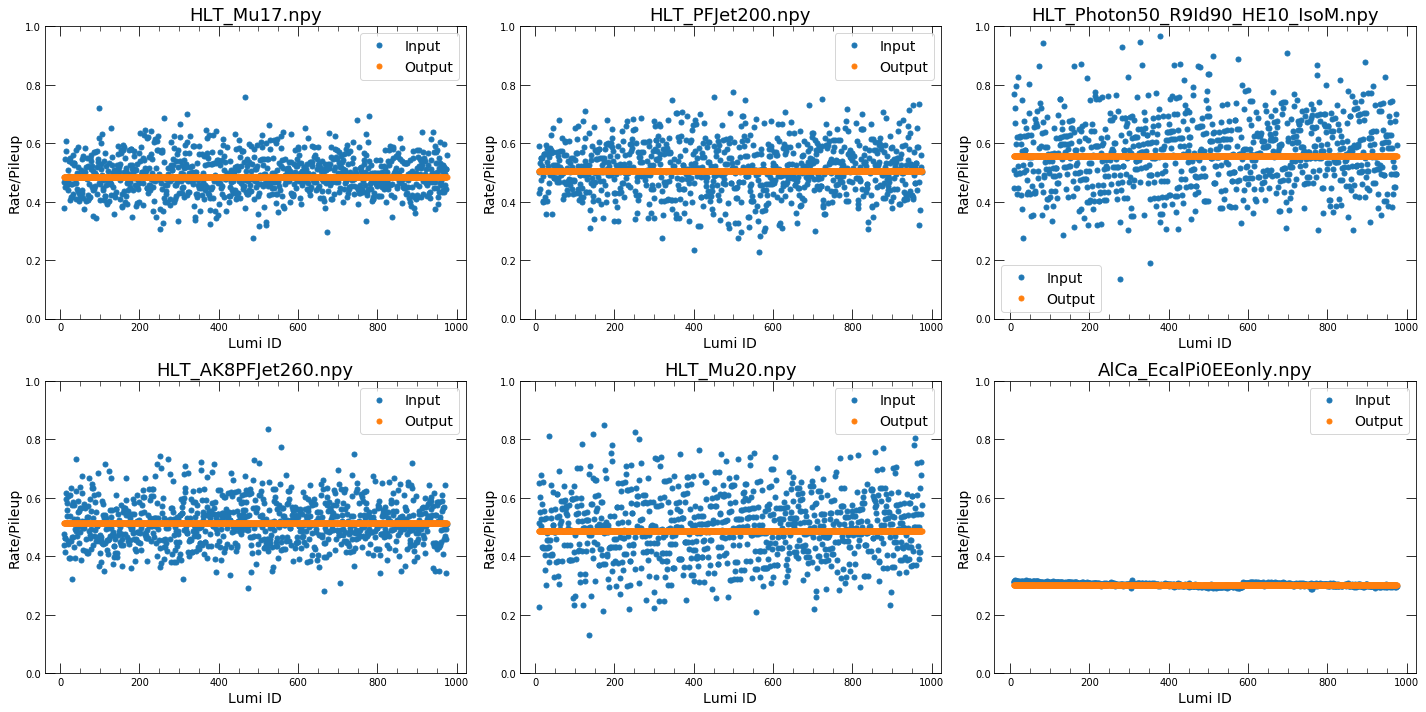

In [72]:
plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(outp[i],inp[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    #plt.scatter(lumi_test,outp[i],label='output',alpha=.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('square')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend()  
    
plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(lumi_test,inp[i],label='Input', linestyle='',marker='o', markersize=5)
    plt.plot(lumi_test,outp[i],label='Output', linestyle='',marker='o', markersize=5)
    plt.title(labels[i])
    plt.xlabel('Lumi ID')
    plt.ylabel('Rate/Pileup')
    ##plt.xlim(0,.5)
    plt.ylim(0,1)
    plt.legend()    
plt.tight_layout()

plt.show()

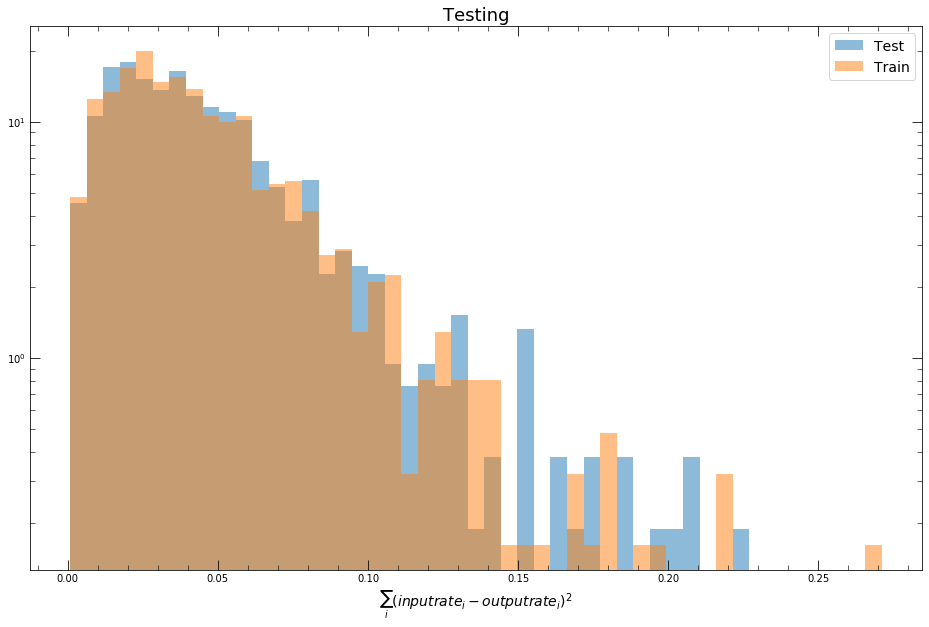

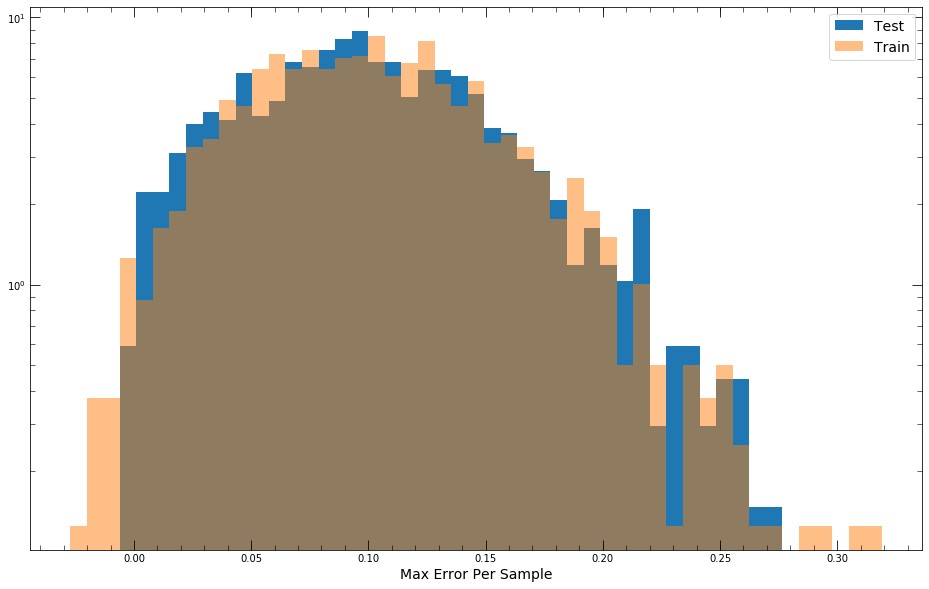

In [73]:
error_test = []
for r in range(len(reconstructed_test)):
    temp = 0
    for s in range(len(reconstructed_test[r])):
        temp+=(reconstructed_test[r][s]-x_test[r][s])**2
    error_test.append(temp)

plt.figure()
bins = np.linspace(min(error_train),max(error_train),50)
plt.hist(error_test,bins=bins,label='Test',alpha=.5,density=True)
plt.hist(error_train,bins=bins,label='Train',alpha=.5,density=True)
plt.legend()
plt.xlabel(sumsquareddif)
plt.title('Testing')
plt.yscale('log')

plt.figure()
bins = np.linspace(min(min(max_error_test),min(max_error_train)),
                   max(max(max_error_test),max(max_error_train)),50)
plt.hist(max_error_test,bins=bins,label='Test',density=True)
plt.hist(max_error_train,bins=bins,label='Train',alpha=.5,density=True)
plt.xlabel('Max Error Per Sample')
plt.legend()
plt.yscale('log')

plt.show()

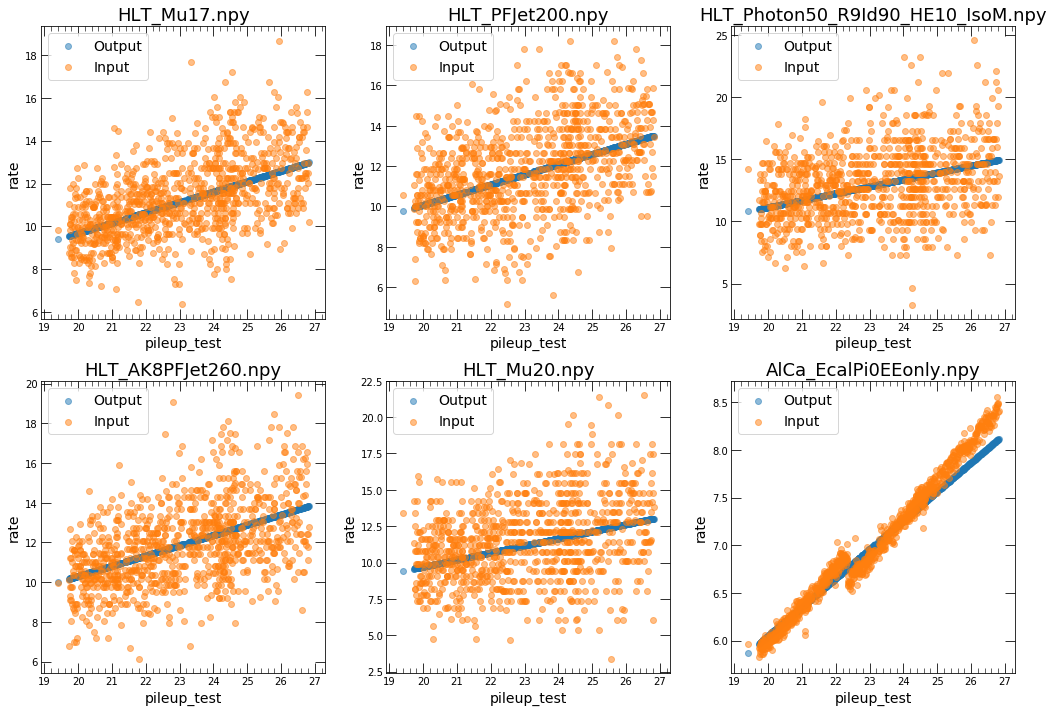

In [74]:
pileup_tt = data[str(runs[2])]['pileup'][0]

output_rates = []
input_rates = []

for r in range(num_rates):
    output_rates.append([])
    input_rates.append([])

for r in range(len(reconstructed_test)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_test[r][o]*pileup_tt[r])
        input_rates[o].append(x_test[r][o]*pileup_tt[r])
    
plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(pileup_tt,output_rates[i],label='Output',alpha=.5)
    plt.scatter(pileup_tt,input_rates[i],label='Input',alpha=.5)
    plt.xlabel('pileup_test')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Fake Bad Data

In [75]:
one_bad = np.array(data[str(runs[2])]['bad_samples'])
print(len(one_bad))

959


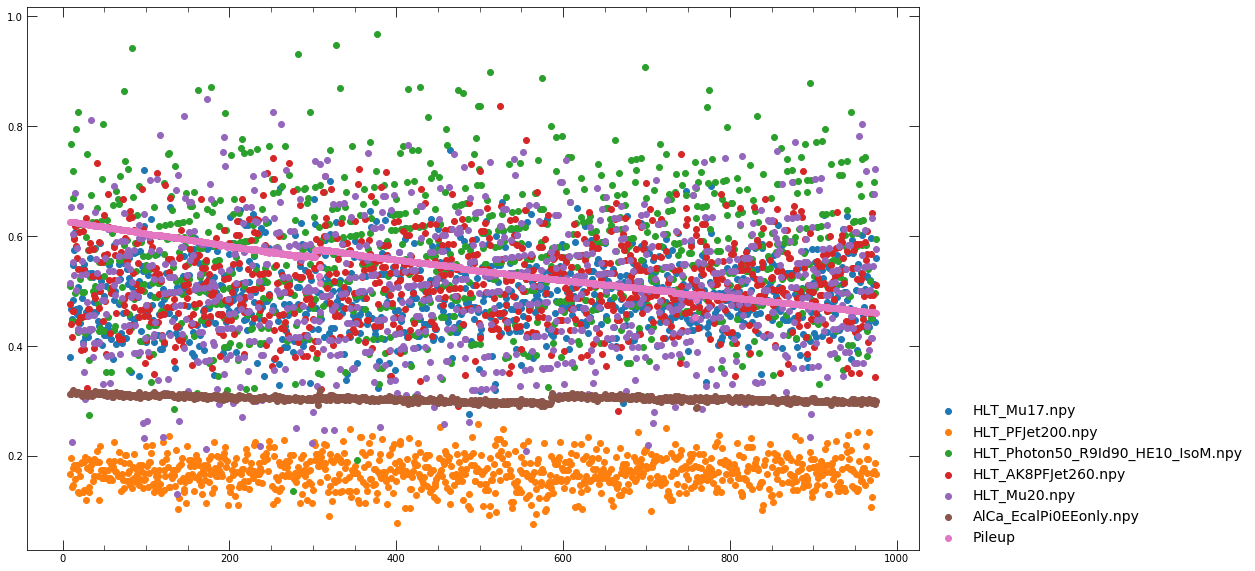

In [76]:
inputs = []
for s in range(len(one_bad)):
    for r in range(len(one_bad[s])):
        if s == 0:
            inputs.append([])
        inputs[r].append(one_bad[s][r])
            
plt.figure()
fig,ax=plt.subplots()
for r in range(len(inputs)):
    ax.scatter(lumi_test,inputs[r],label=labels[r])
ax.scatter(lumi_test,pileup_test,label='Pileup')
ax.legend(loc='lower left', bbox_to_anchor= (1.01, 0), ncol=1, 
              borderaxespad=0, frameon=False)
plt.show()

In [77]:
reconstructed_one_bad = model.predict([np.array(one_bad),pileup_test])

error_one_bad = (x_bad1-reconstructed_one_bad)/(abs(x_bad1)+abs(reconstructed_one_bad))

ValueError: operands could not be broadcast together with shapes (189,6) (959,6) 

In [ ]:
error_reformat_one_bad = []
max_error_one = []
inp_one_bad = []
outp_one_bad = []
for i in range(num_rates):
    error_reformat_one_bad.append([])
    inp_one_bad.append([])
    outp_one_bad.append([])

for i in range(len(error_one_bad)):
    max_error_one.append(max(error_one_bad[i]))
    for j in range(num_rates):
        error_reformat_one_bad[j].append(error_one_bad[i][j])
        outp_one_bad[j].append(reconstructed_one_bad[i][j])
        inp_one_bad[j].append(one_bad[i][j])
            
        

In [ ]:
#bins = np.linspace(0,1,50)
bins  = 'auto'
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_one_bad)):
    plt.subplot(2,3,i+1)
    bins = np.linspace(min(min(error_test_reformat[i]),min(error_reformat_one_bad[i])),max(max(error_test_reformat[i]),max(error_reformat_one_bad[i])),50)
    plt.hist(error_reformat_one_bad[i],bins=bins,label='Good',alpha=.5)
    plt.hist(error_test_reformat[i],bins=bins,label='Fake Bad',alpha=.5)
    plt.xlabel(relativeerror)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi_one_bad = data[str(runs[2])]['lumiid'] 
#print(len(error_reformat_one_bad[0]),len(error_reformat_one_bad0]),len(lumi_one_bad))
#lumi_one_bad = np.linspace(0,len(error_reformat_one_bad[0]),len(error_reformat_one_bad[0]))
plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi_one_bad,error_reformat_one_bad[i],label = 'good', alpha =.5)
    plt.scatter(lumi_test,error_test_reformat[i],label='fake one_bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(outp_one_bad[i],inp_one_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    #plt.axis('square')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend()    
plt.tight_layout()

plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(lumi_test,inp_one_bad[i],label='Input', linestyle='',marker='o', markersize=5)
    plt.plot(lumi_test,outp_one_bad[i],label='Output', linestyle='',marker='o', markersize=5)
    plt.title(labels[i])
    plt.xlabel('Lumi ID')
    plt.ylabel('Rate/Pileup')
    ##plt.xlim(0,.5)
    plt.ylim(0,1)
    plt.legend()    
plt.tight_layout()

plt.show()

In [ ]:
error_one_bad = []
for r in range(len(reconstructed_one_bad)):
    temp = 0
    for s in range(len(reconstructed_one_bad[r])):
        temp+=(reconstructed_one_bad[r][s]-one_bad[r][s])**2
    error_one_bad.append(temp)

plt.figure()
bins = np.linspace(min(min(error_train),min(error_one_bad),min(error_test)),max(max(error_train),max(error_test),max(error_one_bad)),50)
plt.hist(error_test,bins=bins,label='Test',alpha=.5,density=True)
plt.hist(error_train,bins=bins,label='Train',alpha=.5,density=True)
plt.hist(error_one_bad,bins=bins,label="One Fake",alpha=.5,density=True)
plt.legend()
plt.yscale('log')

plt.xlabel(sumsquareddif)

plt.figure()
bins = np.linspace(min(min(max_error_test),min(max_error_train),min(max_error_one)),
                   max(max(max_error_test),max(max_error_train),max(max_error_one)),100)
plt.hist(max_error_test,bins=bins,label='Test',alpha=.5,density=True)
plt.hist(max_error_train,bins=bins,label='Train',alpha=.5,density=True)
plt.hist(max_error_one,bins=bins,label='One Fake',alpha=.5,density=True)
plt.xlabel('Max Error Per Sample')
plt.yscale('log')
plt.legend()

plt.show()

In [ ]:
pileup_one_bad = data[str(runs[2])]['pileup'][0]

output_rates = []
input_rates = []

for r in range(num_rates):
    output_rates.append([])
    input_rates.append([])

for r in range(len(reconstructed_one_bad)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_one_bad[r][o]*pileup_one_bad[r])
        input_rates[o].append(one_bad[r][o]*pileup_one_bad[r])
    
plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(pileup_one_bad,output_rates[i],label='Output',alpha=.5)
    plt.scatter(pileup_one_bad,input_rates[i],label='Input',alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Fake Bad Data - ALL

In [ ]:
all_bad = np.array(data[str(runs[2])]['all_bad_samples'])

In [ ]:
inputs = []
for s in range(len(all_bad)):
    for r in range(len(all_bad[s])):
        if s == 0:
            inputs.append([])
        inputs[r].append(all_bad[s][r])
            
plt.figure()
fig,ax=plt.subplots()
for r in range(len(inputs)):
    ax.scatter(lumi_test,inputs[r],label=labels[r])
ax.scatter(lumi_test,pileup_test,label='Pileup')
ax.legend(loc='lower left', bbox_to_anchor= (1.01, 0), ncol=1, 
              borderaxespad=0, frameon=False)
plt.show()

In [ ]:
reconstructed_all_bad = model.predict([np.array(all_bad),pileup_test])

error_all_bad = (x_bad1-reconstructed_all_bad)/(abs(x_bad1)+abs(reconstructed_all_bad))

In [ ]:
error_reformat_all_bad = []
max_error_all = []
inp_all_bad = []
outp_all_bad = []
for i in range(num_rates):
    error_reformat_all_bad.append([])
    inp_all_bad.append([])
    outp_all_bad.append([])

for i in range(len(error_all_bad)):
    max_error_all.append(max(error_all_bad[i]))
    for j in range(num_rates):
        error_reformat_all_bad[j].append(error_all_bad[i][j])
        outp_all_bad[j].append(reconstructed_all_bad[i][j])
        inp_all_bad[j].append(all_bad[i][j])

In [ ]:
#bins = np.linspace(0,1,50)
bins  = 'auto'
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_all_bad)):
    plt.subplot(2,3,i+1)
    bins = np.linspace(min(min(error_test_reformat[i]),min(error_reformat_all_bad[i])),max(max(error_test_reformat[i]),max(error_reformat_all_bad[i])),50)
    plt.hist(error_test_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_all_bad[i],bins=bins,label='fake all_bad',alpha=.5)
    plt.xlabel(relativeerror)
    plt.legend()
    plt.title(labels[i])

plt.tight_layout()
    
lumi_all_bad = data[str(runs[2])]['lumiid'] 
#print(len(error_reformat_all_bad[0]),len(error_test_reformat0]),len(lumi_all_bad))
#lumi_all_bad = np.linspace(0,len(error_reformat_all_bad[0]),len(error_reformat_all_bad[0]))
plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi_test,error_test_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumi_all_bad,error_reformat_all_bad[i],label='fake all_bad',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])

plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(outp_all_bad[i],inp_all_bad[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('output')
    plt.ylabel('input')
    plt.axis('square')
    #plt.xlim(0,.25)
    #plt.ylim(0,.25)
    plt.legend()    
plt.tight_layout()

plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(lumi_test,inp_all_bad[i],label='Input', linestyle='',marker='o', markersize=5)
    plt.plot(lumi_test,outp_all_bad[i],label='Output', linestyle='',marker='o', markersize=5)
    plt.title(labels[i])
    plt.xlabel('Lumi ID')
    plt.ylabel('Rate/Pileup')
    ##plt.xlim(0,.5)
    ##plt.ylim(0,.5)
    plt.legend()    
plt.tight_layout()

plt.show()

In [ ]:
error_all_bad = []
for r in range(len(reconstructed_all_bad)):
    temp = 0
    for s in range(len(reconstructed_all_bad[r])):
        temp+=(reconstructed_all_bad[r][s]-all_bad[r][s])**2
    error_all_bad.append(temp)

plt.figure()
bins = np.linspace(min(min(error_test),min(error_train),min(error_all_bad)),max(max(error_test),max(error_train),max(error_all_bad)),50)
plt.hist(error_test,bins=bins,label='Test',alpha=.5,density=True)
plt.hist(error_train,bins=bins,label='Train',alpha=.5,density=True)
plt.hist(error_all_bad,bins=bins,label="All Bad",alpha=.5,density=True)
plt.legend()
plt.xlabel(sumsquareddif)
plt.title('All Bad Rates')
plt.yscale('log')

plt.figure()
bins = np.linspace(min(min(max_error_test),min(max_error_train),min(max_error_one),min(max_error_all)),
                   max(max(max_error_test),max(max_error_train),max(max_error_one),max(max_error_all)),100)
plt.hist(max_error_test,bins=bins,label='Test',alpha=.5,density=True)
plt.hist(max_error_train,bins=bins,label='Train',alpha=.5,density=True)
plt.hist(max_error_one,bins=bins,label='One Fake',alpha=.5,density=True)
plt.hist(max_error_all,bins=bins,label='All Fake',alpha=.5,density=True)
plt.xlabel('Max Error Per Sample')
plt.legend()
plt.yscale('log')

plt.show()

In [ ]:
pileup_all_bad = data[str(runs[2])]['pileup'][0]

output_rates = []
input_rates = []

for r in range(num_rates):
    output_rates.append([])
    input_rates.append([])

for r in range(len(reconstructed_all_bad)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_all_bad[r][o]*pileup_all_bad[r])
        input_rates[o].append(all_bad[r][o]*pileup_all_bad[r])
    
plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(pileup_all_bad,output_rates[i],label='Output',alpha=.5)
    plt.scatter(pileup_all_bad,input_rates[i],label='Input',alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Real Bad Data

In [ ]:
reconstructed_realbad2 = model.predict([np.array(x_bad2),pileup_bad2])

error_realbad2 = (x_bad2-reconstructed_realbad2)/(abs(x_bad2)+abs(reconstructed_realbad2))

In [ ]:
inputs = []
for s in range(len(x_bad2)):
    for r in range(len(x_bad2[s])):
        if s == 0:
            inputs.append([])
        inputs[r].append(x_bad2[s][r])
        
lumirealbad2 = bad_data['305588']['lumiid']
        
plt.figure()
fig,ax=plt.subplots()
for r in range(len(inputs)):
    ax.scatter(lumi_realbad2,inputs[r],label=labels[r])
ax.scatter(lumirealbad2,pileup_bad2,label=labels[r])
ax.legend(loc='lower left', bbox_to_anchor= (1.01, 0), ncol=1, 
              borderaxespad=0, frameon=False)
plt.show()

In [ ]:
error_reformat_realbad2 = []
max_error_realbad2 = []
inp_realbad2 = []
outp_realbad2 = []
for i in range(num_rates):
    error_reformat_realbad2.append([])
    inp_realbad2.append([])
    outp_realbad2.append([])

for i in range(len(error_realbad2)):
    max_error_realbad2.append(max(error_realbad2[i]))
    for j in range(num_rates):
        error_reformat_realbad2[j].append(error_realbad2[i][j])
        outp_realbad2[j].append(reconstructed_realbad2[i][j])
        inp_realbad2[j].append(x_bad2[i][j])

In [ ]:
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_realbad2)):
    plt.subplot(2,3,i+1)
    bins = np.linspace(min(min(error_test_reformat[i]),min(error_reformat_realbad2[i])),max(max(error_test_reformat[i]),max(error_reformat_realbad2[i])),50)
    plt.hist(error_test_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_realbad2[i],bins=bins,label='realbad2',alpha=.5)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi_test,error_test_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumirealbad2,error_reformat_realbad2[i],label='realbad2',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(outp_realbad2[i],inp_realbad2[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('ouput')
    plt.ylabel('input')
    plt.axis('square')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.legend()    
plt.tight_layout()

plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(lumirealbad2,inp_realbad2[i],label='Input', linestyle='',marker='o', markersize=5)
    plt.plot(lumirealbad2,outp_realbad2[i],label='Output', linestyle='',marker='o', markersize=5)
    plt.title(labels[i])
    plt.xlabel('Lumi ID')
    plt.ylabel('Rate/Pileup')
    ##plt.xlim(0,.5)
    plt.ylim(0,1)
    plt.legend()    
plt.tight_layout()

plt.show()

In [ ]:
error_realbad2 = []
for r in range(len(reconstructed_realbad2)):
    temp = 0
    for s in range(len(reconstructed_realbad2[r])):
        temp+=(reconstructed_realbad2[r][s]-x_bad2[r][s])**2
    error_realbad2.append(temp)

plt.figure()
bins = np.linspace(min(min(error_test),min(error_realbad2)),max(max(error_test),max(error_realbad2)),75)
plt.hist(error_realbad2,bins=bins,label='Real Bad',density=True)
plt.hist(error_test,bins=bins,label='Test',alpha=.5,density=True)
plt.hist(error_train,bins=bins,label='Train',alpha=.5,density=True)
plt.legend()
plt.title('Sum of the Squared Difference Per Event')
plt.xlabel('Sum of the Squared Distance')
plt.yscale('log')

plt.figure()
bins = np.linspace(min(min(max_error_test),min(max_error_train),min(max_error_realbad2)),
                   max(max(max_error_test),max(max_error_train),max(max_error_realbad2)),75)
plt.hist(max_error_test,bins=bins,label='Test',alpha=.5,density=True)
plt.hist(max_error_train,bins=bins,label='Train',alpha=.5,density=True)
plt.hist(max_error_realbad2,bins=bins,label='Real Bad - 301480',alpha=.5,density=True)
plt.xlabel('Max Error Per Sample')
plt.legend()
plt.yscale('log')

plt.show()

In [ ]:
output_rates = []
input_rates = []

for r in range(num_rates):
    output_rates.append([])
    input_rates.append([])

for r in range(len(reconstructed_realbad2)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_realbad2[r][o]*pileup_bad2[r])
        input_rates[o].append(x_bad2[r][o]*pileup_bad2[r])
    
plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(pileup_bad2,output_rates[i],label='Output',alpha=.5)
    plt.scatter(pileup_bad2,input_rates[i],label='Input',alpha=.5)
    plt.xlabel('pileup')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

## Real Bad Data

In [ ]:
lumirealbad1 = baddata['301480']['lumiid']

reconstructed_realbad1 = model.predict([np.array(x_bad1),pileup_bad1])

error_realbad1 = (x_bad1-reconstructed_realbad1)/(abs(x_bad1)+abs(reconstructed_realbad1))

In [ ]:
inputs = []
for s in range(len(x_bad1)):
    for r in range(len(x_bad1[s])):
        if s == 0:
            inputs.append([])
        inputs[r].append(x_bad1[s][r])
            
plt.figure()
fig,ax=plt.subplots()
for r in range(len(inputs)):
    ax.scatter(lumirealbad1,inputs[r],label=labels[r])
ax.scatter(lumirealbad1,pileup_bad1,label=labels[r])
ax.legend(loc='lower left', bbox_to_anchor= (1.01, 0), ncol=1, 
              borderaxespad=0, frameon=False)
plt.show()

In [ ]:
error_reformat_realbad1 = []
max_error_realbad1 = []
inp_realbad1 = []
outp_realbad1 = []
for i in range(num_rates):
    error_reformat_realbad1.append([])
    inp_realbad1.append([])
    outp_realbad1.append([])

print(len(reconstructed_realbad1),len(error_realbad1))
for i in range(len(error_realbad1)):
    max_error_realbad1.append(max(error_realbad1[i]))
    for j in range(num_rates):
        error_reformat_realbad1[j].append(error_realbad1[i][j])
        outp_realbad1[j].append(reconstructed_realbad1[i][j])
        inp_realbad1[j].append(x_bad1[i][j])

In [ ]:
bins  = 'auto'
plt.figure(figsize=[20,10])
for i in range(len(error_reformat_realbad1)):
    plt.subplot(2,3,i+1)
    #bins = np.linspace(min(min(error_test_reformat[i]),min(error_reformat_realbad1[i])),max(max(error_test_reformat[i]),max(error_reformat_realbad1[i])),50)
    bins = 50
    plt.hist(error_test_reformat[i],bins=bins,label='good',alpha=.5)
    plt.hist(error_reformat_realbad1[i],bins=bins,label='realbad1',alpha=.5)
    plt.xlim(-1.1,1.1)
    plt.legend()
    plt.title(labels[i])
plt.tight_layout()

plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(lumi_test,error_test_reformat[i],label = 'good', alpha =.5)
    plt.scatter(lumirealbad1,error_reformat_realbad1[i],label='realbad1',alpha=.5)
    plt.xlabel('lumi id')
    plt.ylabel('error')
    plt.ylim(-1.1,1.1)
    plt.legend()    
    plt.title(labels[i])
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(outp_realbad1[i],inp_realbad1[i],label=labels[i], linestyle='',marker='o', markersize=3, alpha=0.5)
    plt.xlabel('ouput')
    plt.ylabel('input')
    plt.xlim(-.1,2)
    plt.ylim(-.1,2)
    plt.legend()    
plt.tight_layout()

plt.figure(figsize=[20,10])
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.plot(lumirealbad1,inp_realbad1[i],label='Input', linestyle='',marker='o', markersize=5)
    plt.plot(lumirealbad1,outp_realbad1[i],label='Output', linestyle='',marker='o', markersize=5)
    plt.title(labels[i])
    plt.xlabel('Lumi ID')
    plt.ylabel('Rate/Pileup')
    ##plt.xlim(0,.5)
    plt.ylim(-.1,2)
    plt.legend()    
plt.tight_layout()

plt.show()

In [ ]:
error_realbad1 = []
for r in range(len(reconstructed_realbad1)):
    temp = 0
    for s in range(len(reconstructed_realbad1[r])):
        temp+=(reconstructed_realbad1[r][s]-x_bad1[r][s])**2
    error_realbad1.append(temp)

plt.figure()
bins = np.linspace(min(min(error_realbad1),min(error_test),min(error_train)),max(max(error_realbad1),max(error_test),max(error_train)),50)
plt.hist(error_realbad1,bins=bins,label='RealBad',density=True)
plt.hist(error_test,bins=bins,label='Test',alpha=.5,density=True)
plt.hist(error_train,bins=bins,label='Train',alpha=.5,density=True)
plt.xlabel(sumsquareddif)
plt.legend()
plt.yscale('log')

plt.figure()
bins = np.linspace(min(min(max_error_test),min(max_error_train),min(max_error_realbad1)),
                   max(max(max_error_test),max(max_error_train),max(max_error_realbad1)),75)
plt.hist(max_error_test,bins=bins,label='Test',alpha=.5,density=True)
plt.hist(max_error_train,bins=bins,label='Train',alpha=.5,density=True)
plt.hist(max_error_realbad1,bins=bins,label='Real Bad - 305588',alpha=.5,density=True)
plt.xlabel('Max Error Per Sample')
plt.legend()
plt.yscale('log')

plt.show()

In [ ]:
output_rates = []
input_rates = []

for r in range(num_rates):
    output_rates.append([])
    input_rates.append([])

for r in range(len(reconstructed_realbad1)):
    for o in range(num_rates):
        output_rates[o].append(reconstructed_realbad1[r][o]*pileup_bad1[r])
        input_rates[o].append(x_bad1[r][o]*pileup_bad1[r])
    
plt.figure(figsize=[15,10])
              
for i in range(num_rates):
    plt.subplot(2,3,i+1)
    plt.scatter(pileup_bad1,output_rates[i],label='Output',alpha=.5)
    plt.scatter(pileup_bad1,input_rates[i],label='Input',alpha=.5)
    plt.xlabel('pileup_bad1')
    plt.ylabel('rate')
    plt.title(labels[i])
    plt.legend()

plt.tight_layout()

plt.show()

In [ ]:
plt.figure()
bins = np.linspace(min(min(error_realbad1),min(error_test),min(error_train),min(error_realbad2),min(error_one_bad),min(error_all_bad)),max(max(error_realbad1),max(error_test),max(error_train),max(error_realbad2),max(error_one_bad),max(error_all_bad)),100)
bins = 50
plt.hist(error_realbad1,bins=bins,label='Real Bad',alpha=.5,density=True)
plt.hist(error_realbad2,bins=bins,label='Real Bad',alpha=.5,density=True)
plt.hist(error_one_bad,bins=bins,label='One Bad',alpha=.5,density=True)
plt.hist(error_all_bad,bins=bins,label='All Bad',alpha=.5,density=True)
plt.hist(error_test,bins=bins,label='Test',alpha=.5,density=True)
plt.hist(error_train,bins=bins,label='Train',alpha=.5,density=True)
plt.title('Sum of the Squared Difference Per Event')
plt.xlabel(sumsquareddif)
plt.yscale('log')
plt.xscale('log')
plt.legend()
##plt.ylim(0,100)

plt.figure()
bins = np.linspace(min(min(max_error_test),min(max_error_train),min(max_error_realbad2),
                       min(max_error_realbad1),min(max_error_all),min(max_error_one)),
                   max(max(max_error_test),max(max_error_train),max(max_error_realbad2),
                      max(max_error_realbad1),max(max_error_all),max(max_error_one)),75)
plt.hist(max_error_test,bins=50,label='Test',alpha=.5,density=True)
plt.hist(max_error_train,bins=50,label='Train',alpha=.5,density=True)
plt.hist(max_error_realbad2,bins=bins,label='Real Bad - 301480',alpha=.5,density=True)
plt.hist(max_error_realbad1,bins=bins,label='Real Bad - 305588',alpha=.5,density=True)
plt.hist(max_error_one,bins=50,label='One Fake',alpha=.5,density=True)
plt.hist(max_error_all,bins=50,label='All Fake',alpha=.5,density=True)
plt.xlabel('Max Error Per Sample')
plt.legend()
plt.yscale('log')


plt.show()